## Chapter 3 Homework problem

In [1]:
%%javascript
require.config({
    paths: { 
        d3: 'https://d3js.org/d3.v5.min'
    }
});

<IPython.core.display.Javascript object>

In [2]:
from dag import draw_dag

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline

## Problem 3.2.1

This problem had a lot of variables, and was kind of obnoxious, in my opinion. I am going to simplify the set of variables to actual numbers.

The problem was to look at the overall treatment effect, both by comparing the observed difference in taking drug vs not, and the _causal_ difference between taking the drug vs not.

We have the following DAG

In [4]:
draw_dag({'syndrome': ['treatment', 'outcome'], 'treatment': ['outcome']}, 
        positions = {'syndrome': [200, 50], 'treatment': [80, 150], 'outcome': [320, 150]})

<IPython.core.display.Javascript object>

Lets assign some probabilities.

We are going to try and generate a "Simpson's paradox", so that people more unlikely to recover will try and take the drug more, as there condition is more dire. We are going to be calculating the observed probability $P(\text{recovery}|\text{drug})$ and $P(\text{recovery}|\text{no drug})$, which are the probability _someone selected from the population at random recovers given that they did (or did not) take the drug, respectively_.

It is **not** the probability that someone selected at random and forced to take the drug (or not) would recover.

In [5]:
prob = {'syndrome': 0.4, 
        'drug_given_syndrome': 0.86, 
        'drug_given_no_syndrome': 0.1,
        'recover_given_drug_and_syndrome': 0.42,
        'recover_given_no_drug_and_syndrome': 0.05,
        'recover_given_drug_and_no_syndrome': 0.75,
        'recover_given_no_drug_and_no_syndrome': 0.56
       }

### Analytic approach (observed data)

This uses the fact that the DAG is telling us how the probability factorizes. Specifically

$$P(\text{syndrome, drug, outcome}) = P(\text{outcome} | \text{drug, syndrome})P(\text{drug} | \text{syndrome})P(\text{syndrome})$$

It may be easier to read this right to left (I write it this way to match Pearl): If we were simulating this, we would start with the syndrome, then determine the treatment (drug) as we need syndrome for input, and finally determine the outcome with the two inputs.

To put it another way, we can think of this as a probability tree:

1. Split on syndrome, P(syndrome)
2. Then split on drug, which is P(syndrome|drug) on the edges
3. Then split on recovery, which is P(recovery|drug, syndrome)

To find the total probability of the node P(syndrome, drug, outcome), multiply along the edges.


##### P(drug) [observed]
The probability of needing the drug is just conditional probability: P(A) = $\sum_{b\in B} P(A|B=b)P(B=b)$

In [6]:
prob_drug = (prob['drug_given_syndrome']*prob['syndrome'] +
             prob['drug_given_no_syndrome']*(1-prob['syndrome']))
prob_drug

0.404

In [7]:
prob_recover_given_drug = (
    prob['recover_given_drug_and_syndrome']*prob['drug_given_syndrome']*prob['syndrome'] +
    prob['recover_given_drug_and_no_syndrome']*prob['drug_given_no_syndrome']*(1-prob['syndrome']) 
                          )/prob_drug

In [8]:
prob_recover_given_drug

0.469009900990099

Carrying out the analogous calculation for not taking the drug:

In [9]:
prob_no_drug = 1 - prob_drug

prob_recover_given_no_drug = (
        prob['recover_given_no_drug_and_syndrome']*(1-prob['drug_given_syndrome'])*prob['syndrome'] +
        prob['recover_given_no_drug_and_no_syndrome']*(1-prob['drug_given_no_syndrome'])*(1-prob['syndrome'])
    ) / prob_no_drug

In [10]:
prob_recover_given_no_drug

0.5120805369127518

In [11]:
msg = f"""
i.e. we see that if we aggregate:
* {prob_recover_given_drug:.0%} recover given the drug, vs {prob_recover_given_no_drug:.0%} recover without a drug
"""
print(msg)


i.e. we see that if we aggregate:
* 47% recover given the drug, vs 51% recover without a drug



In [12]:
msg = f"""
If we condition on drug and syndrome, we have:
* Syndrome: {prob['recover_given_drug_and_syndrome']:.0%} recover with drug, vs {prob['recover_given_no_drug_and_syndrome']:.0%} without
* No syndrome: {prob['recover_given_drug_and_no_syndrome']:.0%} recover with drug, vs {prob['recover_given_no_drug_and_no_syndrome']:.0%} without
    """
print(msg)


If we condition on drug and syndrome, we have:
* Syndrome: 42% recover with drug, vs 5% without
* No syndrome: 75% recover with drug, vs 56% without
    


This is our simpson's reversal.

### Via simulation

What if I made an algebra error earlier in the calculation? A simulation is easier to reason about, and sets us up for simulating an intervention in the next section.

In [13]:
def simulate_outcome_single_person(prob):
    """Given the dictionary of probabilities, determines if this person
       recovers or not"""
    def returns_true_with_prob_p(p):
        return random.random() < p
    
    has_syndrome = returns_true_with_prob_p(prob['syndrome'])
    if has_syndrome:
        syndrome_string = 'syndrome'
        takes_drug = returns_true_with_prob_p(prob['drug_given_syndrome'])
    else:
        syndrome_string = 'no_syndrome'
        takes_drug = returns_true_with_prob_p(prob['drug_given_no_syndrome'])
    
    if takes_drug:
        drug_string='drug'
    else:
        drug_string = 'no_drug'

    recovers = returns_true_with_prob_p(prob[f'recover_given_{drug_string}_and_{syndrome_string}'])
    return dict(has_syndrome=has_syndrome, takes_drug=takes_drug, recovers=recovers)

simulate_outcome_single_person(prob)

{'has_syndrome': False, 'takes_drug': False, 'recovers': False}

In [14]:
def simulate_many_people(prob, N=10000):
    return pd.DataFrame([simulate_outcome_single_person(prob) for _ in range(N)])

experiment = simulate_many_people(prob)
experiment

,has_syndrome,takes_drug,recovers
0,False,False,False
1,False,False,True
2,True,True,False
3,True,False,False
4,True,True,False
...,...,...,...
9995,True,True,True
9996,False,True,True
9997,False,False,True
9998,False,False,True


Let's do our different groupby. First, only looking at the drug (not splitting by syndrome):

In [15]:
experiment.groupby('takes_drug').recovers.mean().reset_index()

,takes_drug,recovers
0,False,0.510698
1,True,0.465878


This is pretty close to the answers we saw above in the analytic section.

Now separating by syndrome:

In [16]:
experiment.groupby(['has_syndrome', 'takes_drug']).recovers.mean().reset_index().pivot(index='has_syndrome', columns='takes_drug')

recovers          
takes_drug       False     True 
has_syndrome                    
False         0.558856  0.762069
True          0.053913  0.415217

This also matches what we saw earlier.

## Simulation of "do" calculus

Let's calculate 
$$P(\text{recovery} | \text{do(drug)})$$
first. That is, what would it look like if everyone took the drug? In our simulation, we can just make `prob['drug_given_syndrome']` and `prob['drug_given_no_syndrome']` both equal to 1 (as we are trying to see what the effect of giving the drug would be)

In [17]:
prob_do_drug = {**prob,
                'drug_given_syndrome': 1,
                'drug_given_no_syndrome': 1}

In [18]:
experiment = simulate_many_people(prob_do_drug)
experiment

,has_syndrome,takes_drug,recovers
0,False,True,True
1,True,True,False
2,True,True,False
3,True,True,False
4,True,True,True
...,...,...,...
9995,True,True,False
9996,False,True,False
9997,True,True,False
9998,False,True,True


In this hypothetical world, how many people recover?

In [19]:
P_recover_DO_drug = experiment['recovers'].mean()
P_recover_DO_drug

0.6151

Now let's do the same thing for world where no one took the drug:

In [20]:
prob_do_no_drug = {**prob,
                'drug_given_syndrome': 0,
                'drug_given_no_syndrome': 0}
experiment = simulate_many_people(prob_do_no_drug)
experiment

,has_syndrome,takes_drug,recovers
0,False,False,True
1,False,False,False
2,False,False,True
3,False,False,True
4,True,False,False
...,...,...,...
9995,False,False,False
9996,False,False,False
9997,True,False,False
9998,False,False,False


In [21]:
P_recover_DO_no_drug = experiment['recovers'].mean()
P_recover_DO_no_drug

0.3553

The averge causal effect of the drug is the difference between these two quantities:

In [22]:
P_recover_DO_drug - P_recover_DO_no_drug

0.2598

i.e. About 27pp

### Using the Backdoor criterion to analytically get DO probabilities

Let's first think about this as a tree. Given the factorizaton, we think of our probabilities in a tree as

1. Split on syndrome, P(syndrome)
2. Then split on drug, which is P(drug|syndrome) on the edges
3. Then split on recovery, which is P(recovery|drug, syndrome)

What we really want to do is alter the probabilities in step 2 to be 1 for drug (irrespective of syndrome) and 0 for no_drug (irrespective of syndrome). The probabilities in the tree are telling us _how_ to generate the observed probabilities, so we can in fact use them. This is what we did in the simulation.

Let's do it that way, since we will observe all probabilites. Note this isn't using the BD formula directly, it is just using trees:

In [23]:
draw_dag({'.': ['S', 'NS'], 'S' :['D1', 'ND1'], 'D1': ['R11', 'NR11'], 'ND1':['R10', 'NR10'],
                            'NS':['D0', 'ND0'], 'D0': ['R01', 'NR01'], 'ND0':['R00', 'NR00']},
        positions = {'.': [50,200],
                     'S': [100, 100], 'NS': [100,300],
                     'D1': [200, 50], 'ND1': [200,150],
                     'D0': [200, 250], 'ND0': [200, 350],
                     'R11': [300, 25], 'NR11': [300, 80],
                     'R10': [300, 125], 'NR10': [300, 180],
                     'R01': [300, 225], 'NR01': [300, 275],
                     'R00': [300, 325], 'NR00': [300, 375]
                    })

<IPython.core.display.Javascript object>

We have all the conditional probabilities along this tree, we just want to modify them so that we have the probability of no drug (`ND*`) being 0, and probability of drug being 1. Putting aside the BD criteron and just doing is this way, we get

\begin{align*}
P(\text{recovery} | \text{do(drug)}) =& P(\text{syndrome})\times 1 \times P(\text{recovery} | \text{drug, syndrome})  &\\
& + 0 &\text{(No drug branch)}\\
& + P(\text{no syndrome})\times 1 \times P(\text{recovery} | \text{drug, no syndrome})&\\
& + 0 &\text{(No drug branch)}
\end{align*}

i.e. we replace $P(\text{drug}|*) = 1$ and $P(\text{no drug}|*) = 0$

Looking at the backdoor formula: first we check it applies. Delete the arrow from treatment to outcome, and we need to block syndrome. Then it tells us

$$P(\text{recover} | \text{do(drug)}) = \sum_{s\in\text{syndrome}}P(\text{recover}|\text{drug, s})P(s)$$

Writing this out in full:

\begin{align*}
P(\text{recover} | \text{do(drug)})&=  \sum_{s\in\text{syndrome}}P(\text{recover}|\text{drug, s})P(s)\\
  &=  P(\text{recover}|\text{drug, syndrome})P(\text{syndrome}) +  
      P(\text{recover}|\text{drug, no syndrome})P(\text{no syndrome})
\end{align*}

This is the same as the probability given by the trees!

In [24]:
P_recover_do_drug = (prob['recover_given_drug_and_syndrome']*prob['syndrome'] + 
                     prob['recover_given_drug_and_no_syndrome']*(1-prob['syndrome']))
P_recover_do_drug

0.618

Compare to the simulation result:


In [25]:
# from sim
P_recover_DO_drug

0.6151

Let's look at analytic result for P_recover_do_no_drug

In [26]:
P_recover_do_no_drug = (prob['recover_given_no_drug_and_syndrome']*prob['syndrome'] + 
                        prob['recover_given_no_drug_and_no_syndrome']*(1-prob['syndrome']))


msg=f"""
Analytic result for DO no drug: {P_recover_do_no_drug:.1%}
Simulation result for DO no drug: {P_recover_DO_no_drug:.1%}
"""
print(msg)


Analytic result for DO no drug: 35.6%
Simulation result for DO no drug: 35.5%



#### Conclusions:

* We saw a _risk difference_ P(recover|drug) - P(recover | no drug) = 0.47-0.51 = -0.04
* We saw a _average causal effect_ P(recover|do(drug)) - P(recover|do(no drug)) = 0.618 - 0.356 = 0.262

## 3.3.1: What to block?

This question wasn't terribly applied, but it was relatively straightforward. Given the DAG below, what do we need to block to get the effect of X on Y?

In [27]:
col0, col1, col2 = 100, 200, 300
row0, row1, row2 = 200, 300 ,400 

draw_dag({'B': ['A', 'Z'], 'C':['Z', 'D'],
          'A': ['X'], 'Z':['X', 'Y'], 'D': ['Y'],
          'X': ['W'], 'W': ['Y'], 'Y':[]},
         positions = {'B': [col0, row0], 'C': [col2, row0],
                      'A': [col0, row1], 'Z': [col1, row1], 'D': [col2, row1],
                      'X': [col0, row2], 'W': [col1, row2], 'Y': [col2, row2]})

<IPython.core.display.Javascript object>

a) What are all sets of variables that could be blocked?

Okay, we cannot ever block W, otherwise we cannot measure the direct path. Let's list all paths except `X -> W -> Y`, which is the one we want to measure:

1. `X <- A <- B -> Z <- C -> D -> Y`
2. `X <- A <- B -> Z -> Y`
3. `X <- Z <- C -> D -> Y`
4. `X <- Z -> Y`


* If we control for nothing, 1 is blocked (Z is a collider) but ....
* The only way of blocking 4 is to control $Z$ (which unblocks path 1), but automatically blocks paths 2 and 3

So we must control for $Z$, and then 3 and 4 are automatically blocked. So we just have to think about
1. `X <- A <- B -> Z <- C -> D -> Y`

We can block any non-empty subset of $\{A, B, C, D\}$ in addition to $Z$ to block this path. (This is sort of obnoxious, as there are 2^4 - 1 = 15 different subsets. 

I don't object to the problem, but I don't like just mindless enumeration at the end. The 15 possible sets to control are $\{Z\} \bigcup \{\text{any non empty subset of }A, B, C, D\}$

b) What are the minimal sets that block (i.e. a removal of any controlled variable no longer satisfies the BDC)

This is a much more reasonable question. We need Z and one of A, B, C, D. So the solutions are

1. A and Z
2. B and Z
3. C and Z 
4. D and Z

c) What are the minimal sets for measuring the effect of D on Y?

This one is actually interesting. One minimal set is control for C only (that blocks any backdoor path from $D$, as they all start `D <- C -> Z .......`, so controlling `C` blocks them all).

What if `C` cannot be controlled (e.g. it isn't measured)? The backdoor paths are
1. `D <- C -> Z -> Y` (must control on Z if we cannot control C)
2. `D <- C -> Z <- B -> A -> X -> W -> Y` (Z is a collider, but we control on it for path 1)
3. `D <- C -> Z -> X -> W -> Y`

To block path 1, we block Z, which automatically blocks path 3. So we only need to consider path 2:

`D <- C -> Z <- B -> A -> X -> W -> Y`

We can block this path by blocking A, B, X, or W.

So our minimal sets are

1. C only OR 
2. Z and one of A, B, X, or W

(I claim this is interesting because they are all "minimal sets" even though they are not all the same size)

## 3.3.2: Lord's paradox

We measure weights before and after a diet for two different diet plans. We see that plan B was more likely to be given to people with higher starting weights.

* Looking at weight changes of an individual, $\Delta w = w_f - w_i$, gives a distribution with a mean of 0
* Looking at fixed $w_i$, we can see on a plot of $w_f$ vs $w_i$ that the averages for plan B are higher


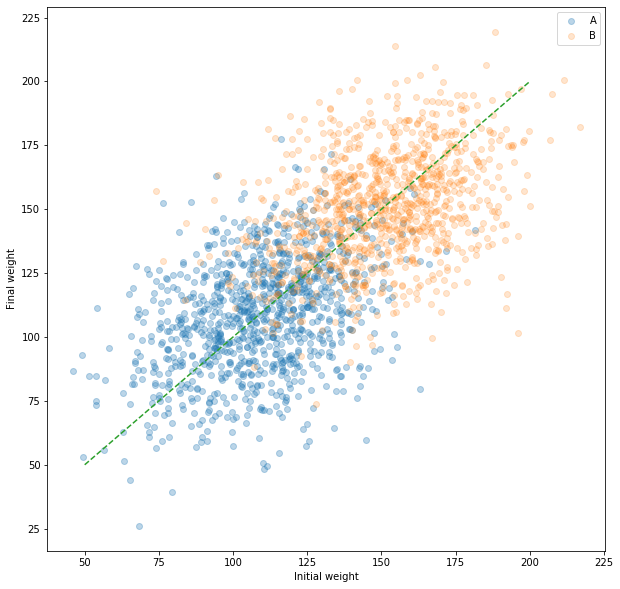

In [28]:
N = 1000
plt.figure(figsize=(10,10))
weight_A = np.random.multivariate_normal(mean=[110, 110], cov=[[500, 200],[200, 500]], size=N)
weight_A_i, weight_A_f = weight_A[:, 0], weight_A[:, 1]

weight_B = np.random.multivariate_normal(mean=[150, 150], cov=[[500, 200],[200, 500]], size=N)
weight_B_i, weight_B_f = weight_B[:, 0], weight_B[:, 1]

plt.plot(weight_A_i, weight_A_f, 'o', label='A', alpha=0.3)
plt.plot(weight_B_i, weight_B_f, 'o', label='B', alpha=0.2)
plt.xlabel('Initial weight')
plt.ylabel('Final weight')
plt.plot([50, 200], [50, 200], '--')
plt.legend()

In [29]:
weight_bin_A_mask = (weight_A_i >= 100) & (weight_A_i <= 115)
weight_bin_B_mask = (weight_B_i >= 100) & (weight_B_i <= 115)


# how do the mean final weights compare in a bin?
weight_A_f[weight_bin_A_mask].mean(), weight_B_f[weight_bin_B_mask].mean() 

(108.24731219224736, 131.83042615900183)

Note that weight B is significantly heavier. How about the weight gain of an individual?

In [30]:
(weight_A[:, 1] - weight_A[:, 0]).mean(), (weight_B[:, 1] - weight_B[:, 0]).mean(), 

(-0.5872257723681727, 0.7706715611383513)

Here the results are "close" to zero (and, depending on the run, it may even look like diet B made people lose weight). Should we bin by initial weight, or not?

It seems we used initial weight to determine which plan to put people in. So we have

In [31]:
draw_dag({'w_i': ['diet' , 'w_f'], 'diet': ['w_f']}, 
         positions={'w_i':[200, 40], 'w_f': [350, 200], 'diet':[50,200]})

<IPython.core.display.Javascript object>

This would tell us that we _should_ control for the initial weight, so the second statistician is correct, and looking at the differences in an individual without stratifying for initial weight is incorrect.

This was a surprising (countintuitive) conclusion, at least for me, but I found [a reference](https://m-clark.github.io/docs/lord/index.html) that backs it up. It does not really provide an intuition, it is more or less a blanket application of Pearl's rules to this problem (i.e. you should condition on a confounder), which just verifies that I am not crazy when trying to apply this.

A much nicer and more illuminating example occurs in the context of education in [this paper](http://www.ccsenet.org/journal/index.php/ijsp/article/view/75051), with a free download. It builds a much better intuition and toy model, and I think it might be worth us digging through more throughly.

## 3.3.3 Lollipop question

This question had to do with a slightly strange experiment. Basically we wanted to introduce something that seemed irrelevant (a lollipop) to a clinical trial, to see how it might break the analysis. Specifically:

- patients are randomly assigned a drug or placebo. Random tells us no incoming arrows to this.
- a nurse hands out lollipops to those who show signs of depression, and mostly among those that have been assigned the drug (the round took the nurse through the treatment ward)

The results of the experiment were:
- over the entire population, the drug was beneficial (vs placebo)
- among those that received lollipops, the drug group did worse
- among those that did not receive lollipops, the drug group did wose

a) If depression contributes to the disease, but lollipop consumption does not, draw a dag that describes this.

In [32]:
draw_dag({'treatment': ['lollipop', 'recovery'],
          'depression': ['lollipop', 'recovery']},
        positions={'treatment': [100, 50], 'lollipop': [200, 50], 'depression': [300, 50], 'recovery': [200,200]})

<IPython.core.display.Javascript object>

**b) What variables have to be controlled for?**

None! The only backdoor path is `treatment -> lollipop <- depression -> recovery`, and `lollipop` is a collider.

**c) The adjustment formula**

The adjustment formula uses the parents of X (or at least the version in 3.7 does) and the parents are the empty set. So we have P(recovery|do(treatment)) = P(recovery|treatment).

We can also get this from the backdoor criterion formula, where the set $Z$ of blocking variables is the empty set.

The intuition here is that because of the random assignment, we expect the contribution of depression to be the same to both the treated and non-treated groups; measuring the average difference in observed effect of treatment should match the average causal effect.

**d) repeat if lollipops are given post-treatment, with a preference of still giving people lollipops that were treated**

This question is actually ill-posed, it depends on how the drug works. I am also assuming that, like in the initial question, the nurse gives lollipops to those that are depressed at the time of distributing lollipops.

_Scenario 1: The drug works to alleviate the disease, but does so in ways other than alliviating depression._

The DAG is exactly the same as before, and the conclusions are the same.

_Scenario 2: One of the methods the drug uses to alleviate the disease is to reduce depression (so being less depressed gives us information on the efficancy of the treatment)__

The DAG looks very different. Let $d_i$ be depression at time of assignment, $d_f$ be depression post treatment. We have


In [33]:
draw_dag({'treatment': ['lollipop', 'recovery'],
          'd_i': ['recovery', 'd_f'],
          'recovery': ['d_f'],
          'd_f': ['lollipop']
         },
        positions={'treatment': [100, 50], 'lollipop': [100, 400], 'd_i': [300, 50], 'recovery': [200,200],
                   'd_f': [300, 400]})

<IPython.core.display.Javascript object>

Even in this case, if we control for nothing, the lollipop is still a collider. We should not control for the lollipop, in fact we should ignore it. Which makes sense -- it has no effect on the experiment, so it is a relief that everyone in the treatment group experiencing something that has no effect on the outcome is not something the experimenter needs to know about. Otherwise, you'd be concerned about "did a clown wander into the room of all the treated patients", etc

## 3.4.1 What to measure

We are going to reuse the DAG from **3.3.1** and ask
> If we want to identify the effect of X on Y, and could only measure X, Y, and one other variable, which should it be?

In [34]:
col0, col1, col2 = 100, 200, 300
row0, row1, row2 = 200, 300 ,400 

draw_dag({'B': ['A', 'Z'], 'C':['Z', 'D'],
          'A': ['X'], 'Z':['X', 'Y'], 'D': ['Y'],
          'X': ['W'], 'W': ['Y'], 'Y':[]},
         positions = {'B': [col0, row0], 'C': [col2, row0],
                      'A': [col0, row1], 'Z': [col1, row1], 'D': [col2, row1],
                      'X': [col0, row2], 'W': [col1, row2], 'Y': [col2, row2]})

<IPython.core.display.Javascript object>

From 3.3.1, we know that all minimal sets for blocking _backdoor_ paths require controlling for _two_ variables (Z and one of A, B, C, and D). So we cannot eliminate backdoor paths.

If we measure W, we can use the _frontdoor_ criterion identify the effect of X on Y.

## 3.4.2 Pharmacy problem

I thought this problem was particularly poorly worded (more on that later). It was a pity, because it had the potential to be a really nice application of the principles.

#### Problem text

We are told

- there are expensive bottles of medicine, and cheap bottles.
- 95% of expensive bottles have "active" medicine (P(active|expensive) = 0.95)
- 5% of cheap bottles have "active" medicine (P(active|cheap) = 0.05)
- all old bottles are cheap, all fresh bottles are expensive

(It is bad pedagogy to have these probabilities add to 1, as there is no reason in principle for them to add to 1)

We are also told that the fraction that recover given the bad bottles (no active ingredient) do much better than those that get bottles with active ingredient.

This suggests the type of problem where people who are more severely affected opt for the more expensive (and generally more effective) treatment, and this selection effect lowers the average relative to those that took the cheap drug. This is where the question really goes bad, as we are explicitly told to assume:

> * Customers have no information about the chemical content of the specific drug they were buying; their choices are influenced by shelf price and age alone.

Shelf and age are not separable/identifiable, which isn't a huge deal. But this statement specifically precludes the choice being made on severity (as customers would be basing their choice on price/age AND severity, and we are told that they are influenced by price/age ALONE). This assumption actually makes the problem unsolvable.

In short, there is a huge difference between what a CUSTOMER uses to make their decision, and what information WE (as analyists) have 

Instead, we assume there is severity effect, and that customers do use it to make their decisions, but we have no access to it.

We are told that we have a list of transactions, that include 

* type of drug purchased (cheap/expensive)
* type of ingredient in bottle
* whether or not the patient recovered

From this information, we are able to determine the the expensive drug is actually more effective (i.e. the ACE for the action "buy expensive bottles" is much better than those that buy cheap bottles)

a) Draw a DAG that identifies the variables in the story

In [35]:
draw_dag({'severity': ['purchase', 'recovery'],
              'purchase': ['active'],
              'active': ['recovery']
             }, positions = {'severity': [200, 50], 'purchase': [30,200], 'active': [200,200],
                             'recovery': [430, 200]})

<IPython.core.display.Javascript object>

b) Construct a data set which is compatible with the story and the claim that we should buy the more expensive drug

Thanks go to Joyce Lee for generating this data:

P(recovery | severe, drug) = 0.6


P(recovery | severe, no drug) = 0.5


P(recovery | mild, drug) = 0.8


P(recovery | mild, no drug) = 0.7

In [36]:
all_data = pd.DataFrame([
    {'S': 'High', 'cost': 'High', 'activity': 'High', 'recovery': 'Y', 'pop': 228},
    {'S': 'High', 'cost': 'High', 'activity': 'High', 'recovery': 'N', 'pop': 152},
    {'S': 'High', 'cost': 'High', 'activity': 'Low', 'recovery': 'Y', 'pop': 10},
    {'S': 'High', 'cost': 'High', 'activity': 'Low', 'recovery': 'N', 'pop': 10},
    {'S': 'High', 'cost': 'Low', 'activity': 'High', 'recovery': 'Y', 'pop': 3},
    {'S': 'High', 'cost': 'Low', 'activity': 'High', 'recovery': 'N', 'pop': 2},
    {'S': 'High', 'cost': 'Low', 'activity': 'Low', 'recovery': 'Y', 'pop': 47.5},
    {'S': 'High', 'cost': 'Low', 'activity': 'Low', 'recovery': 'N', 'pop': 47.5},
    {'S': 'Low', 'cost': 'High', 'activity': 'High', 'recovery': 'Y', 'pop': 76},
    {'S': 'Low', 'cost': 'High', 'activity': 'High', 'recovery': 'N', 'pop': 19},
    {'S': 'Low', 'cost': 'High', 'activity': 'Low', 'recovery': 'Y', 'pop': 3.5},
    {'S': 'Low', 'cost': 'High', 'activity': 'Low', 'recovery': 'N', 'pop': 1.5},
    {'S': 'Low', 'cost': 'Low', 'activity': 'High', 'recovery': 'Y', 'pop': 16},
    {'S': 'Low', 'cost': 'Low', 'activity': 'High', 'recovery': 'N', 'pop': 4},
    {'S': 'Low', 'cost': 'Low', 'activity': 'Low', 'recovery': 'Y', 'pop': 266},
    {'S': 'Low', 'cost': 'Low', 'activity': 'Low', 'recovery': 'N', 'pop': 114},
])
    
    

In [37]:
# Restrict to the things we can measure
our_data = all_data.groupby(['cost', 'activity', 'recovery'], as_index=False).pop.sum()

our_data

,cost,activity,recovery,pop
0,High,High,N,171.0
1,High,High,Y,304.0
2,High,Low,N,11.5
3,High,Low,Y,13.5
4,Low,High,N,6.0
5,Low,High,Y,19.0
6,Low,Low,N,161.5
7,Low,Low,Y,313.5


Let's check the claim made by the story: 
> _the percentage of recovery [sic] amongst those that got bad bottles, with none of the active ingredient, is still much higher than among those that got good bottles, with the active ingredient._

In [38]:
(our_data
 .groupby(['activity', 'recovery'], as_index=True)['pop'].sum()
 .reset_index()
 .pivot_table(index='activity', columns='recovery', values='pop')
 .apply(lambda x: x/x.sum(), axis=1)
)

#our_data

recovery,N,Y
activity,,
High,0.354,0.646
Low,0.346,0.654


We see there is a (small) increase in the recovery rate amongst those that take the inactive drug. 


Let's try to measure the counter-factual, using the observational data only by asking what would happen if we gave everyone -- irrespective of the severity -- the drug.


$$P(\text{recovery} | \text{do(cost=high)}) = \sum_{\text{activity}} P(\text{activity}|\text{cost=high}) \left(\sum_{\text{costs} x'} P(\text{recovery}|\text{x', activity})P(\text{x'})\right)$$

                            = P(activity=High|cost=high) (P(recovery| cost=low, activity=High)P(cost=low) + 
                                                          P(recovery| cost=high, activity=High)P(cost=high)) +
                              P(activity=Low|cost=high)  (P(recovery| cost=low, activity=Low)P(cost=low) + 
                                                          P(recovery| cost=high, activity=Low)P(cost=high))

                            = (0.95) ((19/25) x 0.5 + 
                                      (304/475) x 0.5) +
                              (0.05) ((313.5/475) x 0.5 + 
                                      (13.5/25) x 0.5)

In [39]:
(0.95)*((19/25) + (304/475))*0.5 + (0.05)*0.5*((313.5/475) + 13.5/25)

0.695

P(recovery | do(cost=low)) = \sum_activity P(activity|cost=low) (\sum_{costs x'} P(recovery|x', activity)P(x'))

                            = P(activity=High|cost=low) (P(recovery| cost=low, activity=High)P(cost=low) + 
                                                          P(recovery| cost=high, activity=High)P(cost=high)) +
                              P(activity=Low|cost=low)  (P(recovery| cost=low, activity=Low)P(cost=low) + 
                                                          P(recovery| cost=high, activity=Low)P(cost=high))

In [40]:
(0.05)*((19/25) + (304/475))*0.5 + (0.95)*0.5*((313.5/475) + 13.5/25)

0.6050000000000001

## 3.5.1 Covariate specific effects

This question looks at covariate specific effects under intervention. It is basically the same as applying the backdoor formula, with the following exceptions:

1. The variable you are looking at covariate specific effects must be in the "controlling" set when determining backdoor paths (as we are setting it to a specific level)
2. When summing over the set we are controlling over, we sum over all _other_ variables in the set, except for the one we are fixing for intervention.

We are using the DAG from earlier. Recall the minimal sets for the effect of X on Y were
- Z and one of \{A, B, C, D\}

In [41]:
col0, col1, col2 = 100, 200, 300
row0, row1, row2 = 200, 300 ,400 

draw_dag({'B': ['A', 'Z'], 'C':['Z', 'D'],
          'A': ['X'], 'Z':['X', 'Y'], 'D': ['Y'],
          'X': ['W'], 'W': ['Y'], 'Y':[]},
         positions = {'B': [col0, row0], 'C': [col2, row0],
                      'A': [col0, row1], 'Z': [col1, row1], 'D': [col2, row1],
                      'X': [col0, row2], 'W': [col1, row2], 'Y': [col2, row2]})

<IPython.core.display.Javascript object>

**a) Find an expression for the $c$-specific effect of X on Y:**

The simplest blocking set that includes $C$ is $\{Z, C\}$. If we were doing just the ordinary "do" calculus, we have
$$P(Y|\text{do(X=x)}) = \sum_{c, z} P(Y | \text{X=x}, \text{C=c}, \text{Z = z})P(\text{C=c}, \text{Z=z})$$

If we want the effect when $C$ takes a specific value $c$ we get
$$P(Y|\text{do(X=x)}, \text{C=c}) = \sum_{z} P(Y | \text{X=x}, \text{C=c}, \text{Z = z})P(\text{Z=z}|\text{C=c})$$

This does not match **Rule 2** as printed in the book (it would have $P(Z=z)$ at the end, rather than $P(Z=z|C=c)$). This is corrected in the [errata](http://bayes.cs.ucla.edu/PRIMER/pearl-etal-2016-primer-errata-pages-april2020.pdf). The corrected form is also given in the discussion around equation (3.11)

**b) Identify a set of four variables for getting the $z$ specific effect of X on Y**

So we know a minimal set to control for are $\{C, Z\}$, so the four things we are going to measure are X, Y, Z, and C (C could be replaced with A, B, or D). The formula for intervention is simple, we can just swap the Zs and Cs above:

$$P(Y|\text{do(X=x)}, \text{Z=z}) = \sum_{c} P(Y | \text{X=x}, \text{C=c}, \text{Z = z})P(\text{C=c}|\text{Z=z})$$

**c) What is the expected value of Y under a Z-dependent treatment, where X is set to 0 when is <= 2, and 1 otherwise? Z takes values 0 through 5**

Let's assume $y$ is binary, 0 or 1, and that we are interested in the expected number of positive cases (1)


\begin{align*}
E(Y|\text{strat}) &= \sum_{y} y P(Y=y|\text{strat})\\
=& P(Y=1 | \text{strat})\\
=& P(Y=1 | \text{do(X=0)}, Z=0)P(Z=0) + P(Y=1 | \text{do(X=0)}, Z=1)P(Z=1) + P(Y=1 | \text{do(X=0)}, Z=2)P(Z=2)\\
 & + P(Y=1 | \text{do(X=1)}, Z=3)P(Z=3) + P(Y=1 | \text{do(X=1)}, Z=0)P(Z=0) + P(Y=1 | \text{do(X=1)}, Z=1)P(Z=1) + P(Y=1 | \text{do(X=1)}, Z=5)P(Z=5)\\
=& \sum_{z=0}^2 P(Y=1|\text{do(X=0)}, Z=z)P(Z=z) + \sum_{z=3}^{5}P(Y=1|\text{do(X=1)}, Z=z)P(Z=z)\\
=& \sum_{c}\left(\sum_{z=0}^2 P(Y=1|X=0, C=c, Z=z)P(C=c|Z=z)P(Z=z) + \sum_{z=3}^{5}P(Y=1|X=1, C=c, Z=z)P(C=c|Z=z)P(Z=z)\right)
\end{align*}

I don't really find this particularly enlightening. Would be better with a numeric example -- this doesn't feel like too much more than just expanding the formula to some arbitrary point.

## Study problem 3.8.1

I think this problem is interesting, although I wish it were a little more directed. Let's approach this using the diagram we already have, and we will label the structural coefficients as `c[(source, dest)]`.

We will approach this as a simulation approach in parallel.

In [52]:
col0, col1, col2 = 100, 200, 300
row0, row1, row2 = 200, 300 ,400 

N = 15000

draw_dag({'B': ['A', 'Z'], 'C':['Z', 'D'],
          'A': ['X'], 'Z':['X', 'Y'], 'D': ['Y'],
          'X': ['W'], 'W': ['Y'], 'Y':[]},
         positions = {'B': [col0, row0], 'C': [col2, row0],
                      'A': [col0, row1], 'Z': [col1, row1], 'D': [col2, row1],
                      'X': [col0, row2], 'W': [col1, row2], 'Y': [col2, row2]})

<IPython.core.display.Javascript object>

In [53]:
from sklearn.linear_model import LinearRegression

c = {
    ('B','A'): 2.3, ('B', 'Z'): 3.3,
    ('C','D'): 1.0, ('C', 'Z'): -1.5,
    ('A', 'X'): 2.0,
    ('D', 'Y'): 3.4,
    ('Z', 'X'): 2.6, ('Z', 'Y'): 0.7,
    ('X', 'W'): 1.1,
    ('W', 'Y'): 1.6
}

def noise(scale):
    return np.random.normal(scale=scale, size=N)


B = noise(scale=0.3)
C = noise(scale=0.6)

A = B*c[('B', 'A')] + noise(scale=0.1)
D = C*c[('C', 'D')] + noise(scale=0.15)
Z = B*c[('B', 'Z')] + C*c[('C', 'Z')] + noise(scale=0.4)

X = A*c[('A', 'X')] + Z*c[('Z', 'X')] + noise(scale=0.3)
W = X*c[('X', 'W')] + noise(scale=0.2)
Y = W*c[('W', 'Y')] + Z*c[('Z', 'Y')] + D*c[('D', 'Y')] + noise(scale=0.35)

data = pd.DataFrame({'A':A, 'B':B, 'C':C, 'D':D, 'W':W, 'X':X, 'Y':Y, 'Z':Z})

linear = LinearRegression()

**b) Assuming we can measure X, Y, W, and Z. What is a testable implication**

Regressing $W \sim X$ should give us `c[(X,W)]`, and I would also think that $Y \sim W$ should give `c[(W,Y)]`. Let's check it out: 

In [65]:
def get_coefs(control_names, target_name, data=data):
    linear=LinearRegression().fit(data[control_names], data[target_name])
    return { var_name: value for var_name, value in zip(control_names, linear.coef_)}

def report(control_names, target_name, data=data):
    coef=get_coefs(control_names, target_name, data)
    for var_name, value in coef.items():
        if (var_name, target_name) not in c:
            continue
        struct = c[(var_name, target_name)]
        msg = f"""({var_name}, {target_name}): fit value is {value:.3f}, structural value is {struct:.3f}"""
        print(msg)
        

In [66]:
report(['X'], 'W')

(X, W): fit value is 1.100, structural value is 1.100


In [67]:
report(['W'], 'Y')

(W, Y): fit value is 1.588, structural value is 1.600


For the record, let's show that $Y \sim Z$ does **not** produce the structural result.

In [68]:
report(['Z'], 'Y')

(Z, Y): fit value is 5.542, structural value is 0.700


**d) If we only measured X, W, and Y, can we get the total effect of X on Y?**

Yes.

It seems like we can identify the total effect of X on Y, as we have W:

- X to W is identifible, with 1.100
- W to Y is identifible, with 1.600

So the causal effect X to Y is $1.10 \times 1.60 = 1.76$.

**e) If we regress $B$ on all other parameters in the model, which coefficient will be zero?**

Le sigh. These questions are so ambigously worded. If this question means
$$ B \sim A + C + D + Z + X + Y + W $$
then I see _multiple_ coefficients that will be zero. For each variable, we assume all other variables are controlled for. Non-zero coefficients are 
- A (direct connection from B to A)
- Z (direct connection from B to Z)
- C (path B -> Z <- C is unblocked by controlling for Z)

Every other path through A and Z is blocked by controlling for those, so the rest are zero (or statistically insignificant)

In [71]:
get_coefs(['A', 'C', 'D', 'Z', 'X', 'Y', 'W'], 'B')

{'A': 0.3810216973928448,
 'C': 0.052205667929758955,
 'D': -0.0023843490978844384,
 'Z': 0.039121658214295,
 'X': -0.001549953532486801,
 'Y': 0.0002993999782092724,
 'W': -0.0007430271849100148}

Note that A, C, and Z coefficients are at least 10 times bigger than the other coefficients.

If the question means
$$B \sim X_i$$
by doing coefficient one at a time, then we are asking which variables are $d$-separated when we control for nothing on the original graph. From our strutural equations, we see $B$ and $C$ are independent when conditioning on nothing. Let's go through the formualism. Let's enumerate all paths from B to C

1. `B -> Z <- C` (blocked by Z)
2. `B -> Z -> Y <- D <- C` (blocked by Y)
3. `B -> Z -> X -> W -> Y <- D <- C` (blocked by Y)
4. `B -> A -> X <- Z <- C` (blocked by X)
5. `B -> A -> X <- Z -> Y <- D <- C` (blocked by X and by Y)
6. `B -> A -> X -> W -> Y <- D <- C` (blocked by X)


In [72]:
get_coefs(['C'], 'B')

{'C': -0.0016298862742715455}

Let's compare to other pairs, and show this is the only one

In [83]:
nodes = ['A', 'C', 'D', 'W', 'X', 'Y', 'Z']
node1='B'
for node2 in nodes:
    coef = list(get_coefs([node2], node1).values())[0]
    if abs(coef) < 0.02:
        prefix = "\t\t\t"
    else:
        prefix = ""
    print(f'{prefix}{node1},{node2}: {coef:.3f}')

B,A: 0.426
			B,C: -0.002
			B,D: 0.000
B,W: 0.048
B,X: 0.053
B,Y: 0.032
B,Z: 0.151


Going through the path exercise, it makes sense that B and D are independent (as are A and C, and A and D when looking at the entire graph).

Again, this question should not be phrased as _which coefficient_ (singular) should be zero? There are multiple zero coefficients! (i.e. variables that are independent, controlling for nothing)

**f) skip**

Given the phrasing in (e) and the miscounting in the question, I don't want to look for 5 such regression coefficients! The next question is more interesting.

**g) Assume C and D cannot be measured. Find a way to estimate `c[(Z,Y)]`**

The hint that we are given turn $B$ into an instrumental variable 